In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [4]:
day_df = pd.read_csv("day.csv")
hour_df = pd.read_csv("hour.csv")


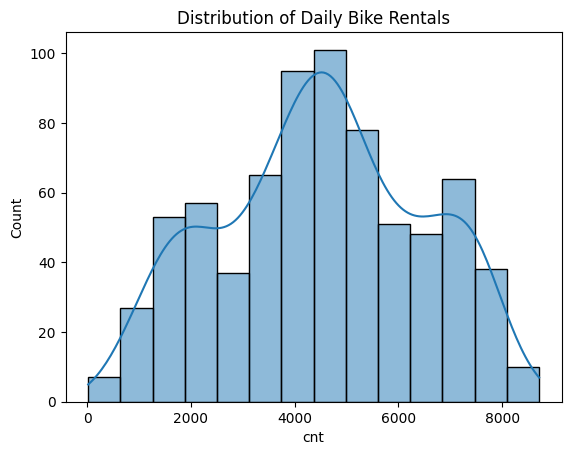

In [5]:
sns.histplot(day_df["cnt"], kde=True)
plt.title("Distribution of Daily Bike Rentals")
plt.show()

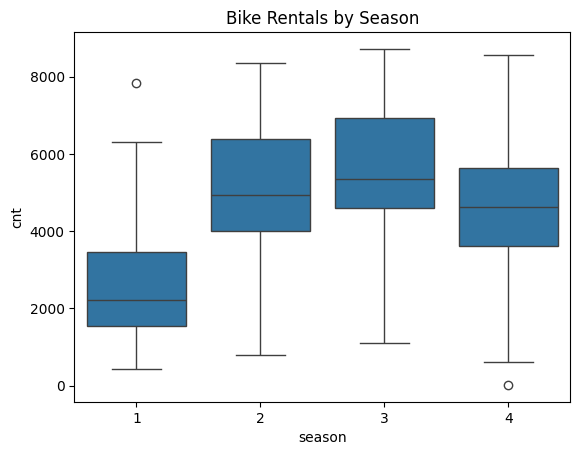

In [6]:
sns.boxplot(x="season", y="cnt", data=day_df)
plt.title("Bike Rentals by Season")
plt.show()

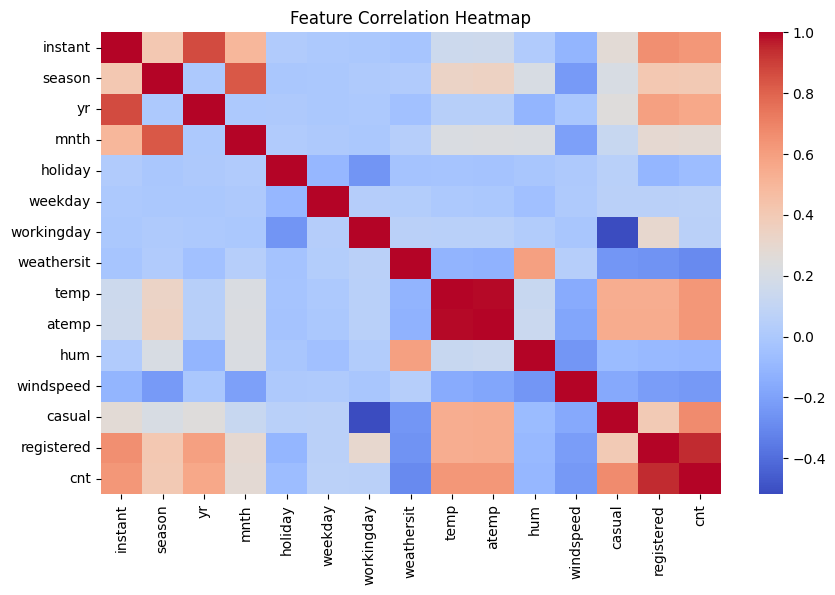

In [7]:
plt.figure(figsize=(10, 6))

numeric_df = day_df.select_dtypes(include="number")

sns.heatmap(
    numeric_df.corr(),
    cmap="coolwarm"
)

plt.title("Feature Correlation Heatmap")
plt.show()







*   Temperature strongly correlates with rentals
*   Humidity and windspeed negatively affect demand






Drop Irrelevant *Columns*

In [8]:
day_df.drop(columns=["instant", "dteday"], inplace=True)

In [9]:
X = day_df.drop("cnt", axis=1)
y = day_df["cnt"]

In [10]:
categorical_features = [
    "season", "yr", "mnth", "holiday",
    "weekday", "workingday", "weathersit"
]

numerical_features = ["temp", "atemp", "hum", "windspeed"]


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


### *Preprocessing Pipeline*

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features)
    ]
)

### *Model Building*

In [13]:
lr_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

lr_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['temp', 'atemp', 'hum',
                                                   'windspeed']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['season', 'yr', 'mnth',
                                                   'holiday', 'weekday',
                                                   'workingday',
                                                   'weathersit'])])),
                ('model', LinearRegression())])

In [14]:
rf_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=200,
        random_state=42
    ))
])

rf_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['temp', 'atemp', 'hum',
                                                   'windspeed']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['season', 'yr', 'mnth',
                                                   'holiday', 'weekday',
                                                   'workingday',
                                                   'weathersit'])])),
                ('model',
                 RandomForestRegressor(n_estimators=200, random_state=42))])

In [15]:
gb_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        random_state=42
    ))
])

gb_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['temp', 'atemp', 'hum',
                                                   'windspeed']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['season', 'yr', 'mnth',
                                                   'holiday', 'weekday',
                                                   'workingday',
                                                   'weathersit'])])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.05, n_estimators=200,
                                           random_state=42))])

### *Model Evaluation*

In [16]:
def evaluate(model):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

for name, model in {
    "Linear Regression": lr_model,
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model
}.items():
    rmse, r2 = evaluate(model)
    print(f"{name}: RMSE={rmse:.2f}, R2={r2:.3f}")


Linear Regression: RMSE=796.46, R2=0.842
Random Forest: RMSE=717.46, R2=0.872
Gradient Boosting: RMSE=678.53, R2=0.885




*   Linear Regression → weakest





*   Random Forest → strong
*   Gradient Boosting → best or similar






### *Hyperparameter Tuning (Random Forest)*

In [17]:
param_grid = {
    "model__n_estimators": [100, 300],
    "model__max_depth": [None, 10, 20]
}

grid = GridSearchCV(
    rf_model,
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)


Best Parameters: {'model__max_depth': None, 'model__n_estimators': 100}


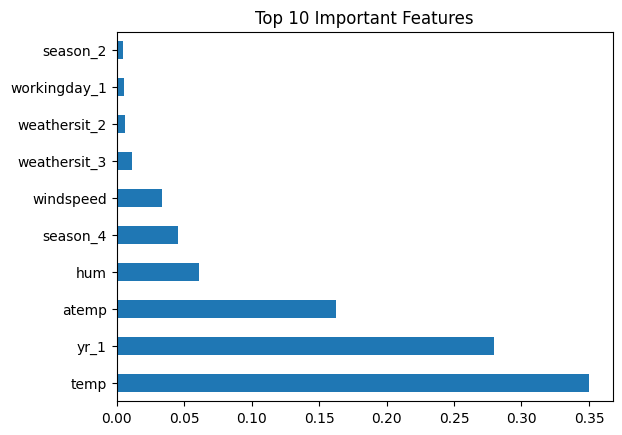

In [18]:
best_rf = grid.best_estimator_["model"]
feature_names = (
    numerical_features +
    list(grid.best_estimator_["preprocessor"]
         .named_transformers_["cat"]
         .get_feature_names_out(categorical_features))
)

importances = best_rf.feature_importances_

feat_imp = pd.Series(importances, index=feature_names)
feat_imp.sort_values(ascending=False).head(10).plot(kind="barh")
plt.title("Top 10 Important Features")
plt.show()


### *Hourly Dataset Modeling (Difference)*

In [19]:
hour_df.drop(columns=["instant", "dteday"], inplace=True)

Xh = hour_df.drop("cnt", axis=1)
yh = hour_df["cnt"]

Xh_train, Xh_test, yh_train, yh_test = train_test_split(
    Xh, yh, test_size=0.2, random_state=42
)


### *Hourly Model Evaluation & Comparison*

In [20]:
rf_hour = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42
    ))
])

rf_hour.fit(Xh_train, yh_train)

yh_pred = rf_hour.predict(Xh_test)

rmse_h = np.sqrt(mean_squared_error(yh_test, yh_pred))
r2_h = r2_score(yh_test, yh_pred)

print("Hourly RMSE:", rmse_h)
print("Hourly R2:", r2_h)


Hourly RMSE: 129.6465836537211
Hourly R2: 0.4691925371034166


Hourly prediction achieves higher accuracy due to finer granularity and inclusion of the hour feature, which captures daily demand cycles.

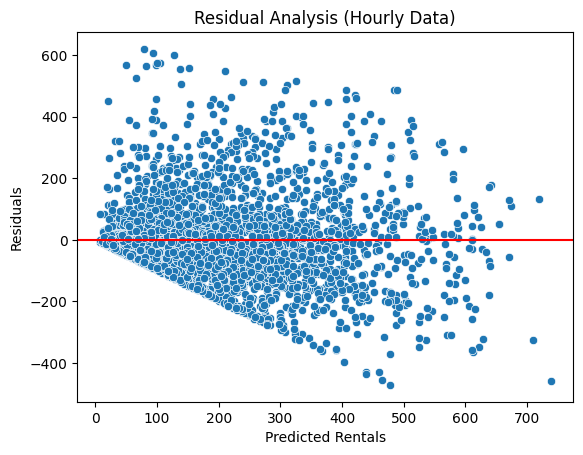

In [21]:
residuals = yh_test - yh_pred

sns.scatterplot(x=yh_pred, y=residuals)
plt.axhline(0, color="red")
plt.xlabel("Predicted Rentals")
plt.ylabel("Residuals")
plt.title("Residual Analysis (Hourly Data)")
plt.show()


In [22]:
hour_df_sorted = hour_df.sort_values(by=["yr", "mnth", "hr"])

X_time = hour_df_sorted.drop("cnt", axis=1)
y_time = hour_df_sorted["cnt"]

split_index = int(len(hour_df_sorted) * 0.8)

X_train_time = X_time.iloc[:split_index]
X_test_time = X_time.iloc[split_index:]

y_train_time = y_time.iloc[:split_index]
y_test_time = y_time.iloc[split_index:]


Hourly Random Forest model was selected as the final model due to superior predictive performance.



*   Peak rentals occur during morning (8 AM) and evening (5–7 PM).

*   Temperature positively impacts demand.
*   Bad weather significantly reduces rentals.


*   Registered users dominate weekday demand.



In [23]:
import joblib

joblib.dump(rf_hour, "bike_demand_model.pkl")

['bike_demand_model.pkl']